# Simulated Annealing

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using simulated annealing

__SIMULATED-ANNEALING__(_source_ , _destination_ , schedule) __returns__ a route  
&emsp;_current_ &larr; random-route between _source_ and _destination_  
&emsp;__for__ _t_ &larr; __to__ $\inf$  
&emsp;&emsp; _T_ &larr; _schedule(t)_  
&emsp;&emsp; __if__ _T_ = 0 __then__ __return__ _current_  
&emsp;&emsp; _neighbors_ &larr; _current_.NEIGHBOURS  
&emsp;&emsp; _next_ &larr; randomly choose one state from _neighbors_  
&emsp;&emsp; _$\Delta$_ _E_ &larr; _next_._COST_ - _current_._COST_  
&emsp;&emsp; __if__ _$\Delta$_ _E_ &lt; 0 __then__ _current_ &larr; _next_    
&emsp;&emsp; __else__ _current_ &larr; _next_ only with probability of ${e}^{\frac{\Delta E}{T}}$  
&emsp;__endfor__

In [ ]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet;

# You need to upload Utilities.zip in /content directory which is the default
!unzip Utilities.zip

In [1]:
import osmnx as ox
import numpy as np
import time, sys, itertools
from collections import deque
from tqdm import tqdm
from utilities import *

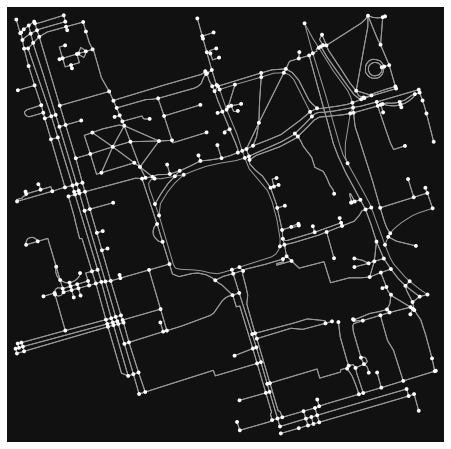

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

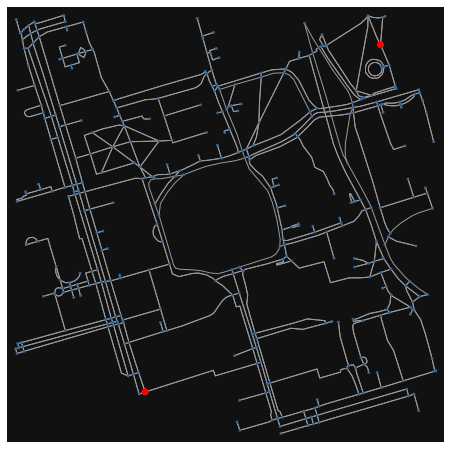

In [3]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [5]:
%%capture
source(Node)

We need to generate a random path from source and destination to be the starting state in simulated annealing. The following algorithms is just a variant of graph search but instead of choosing the node to be expanded based on a certain policy like bfs/dfs, we just choose the node randomly from the frontier.

In [6]:
source(randomized_search)

The default of the schedule function is that the initial temperature is 20 and it gets terminated after 100 unit time.

In [7]:
source(exp_schedule)

In [8]:
schedule = exp_schedule(200, 0.05, 10000)

In [9]:
states = []

In [ ]:
%%time
states = []
current = randomized_search(G, 55808290, 389677909)

for t in tqdm(range(sys.maxsize)):
    T = schedule(t)
    states.append(cost(G, current))
    
    if T < 0.00000001:
        route = current
        break
    
    # generate 5 more paths to choose from
    neighbors = [*itertools.islice(children_route(G, current), 100)]
    next_choice = random.choice(neighbors)
    
    delta_e = cost(G, next_choice) - cost(G, current)  
    if delta_e < 0 or probability(np.exp(-1 * delta_e/T)):
        current = next_choice
        
    print(cost(G, current))
    

  0%|          | 1/9223372036854775807 [00:06<16976455256982887:32:16,  6.63s/it]

1081.9560000000001


  0%|          | 2/9223372036854775807 [00:13<17339468549993904:21:20,  6.77s/it]

1146.333


  0%|          | 3/9223372036854775807 [00:21<17941878583021367:45:04,  7.00s/it]

1146.333


  0%|          | 4/9223372036854775807 [00:28<18446732482413629:26:24,  7.20s/it]

1057.167


  0%|          | 5/9223372036854775807 [00:37<19830450672539898:18:40,  7.74s/it]

1584.2269999999999


  0%|          | 6/9223372036854775807 [00:45<19591290643303171:24:48,  7.65s/it]

1631.5059999999999


  0%|          | 7/9223372036854775807 [00:53<20005432862756552:14:56,  7.81s/it]

1079.0790000000002


  0%|          | 8/9223372036854775807 [01:01<19853078053356832:59:44,  7.75s/it]

1301.1730000000002


  0%|          | 9/9223372036854775807 [01:09<20205872348567263:00:16,  7.89s/it]

1301.1730000000002


  0%|          | 10/9223372036854775807 [01:17<20343742691339962:35:44,  7.94s/it]

1301.1730000000002


  0%|          | 11/9223372036854775807 [01:26<20839287607493008:29:52,  8.13s/it]

1264.2940000000003


  0%|          | 12/9223372036854775807 [01:33<20134829041208326:49:36,  7.86s/it]

1264.2940000000003


  0%|          | 13/9223372036854775807 [01:40<19530995286977269:45:36,  7.62s/it]

1035.391


  0%|          | 14/9223372036854775807 [01:51<21957493732257528:02:08,  8.57s/it]

1118.969


  0%|          | 15/9223372036854775807 [01:57<20526193368543596:05:20,  8.01s/it]

1078.717


  0%|          | 16/9223372036854775807 [02:04<19330208866280916:45:52,  7.54s/it]

1078.0030000000002


  0%|          | 17/9223372036854775807 [02:10<18690552842689014:53:52,  7.30s/it]

1036.9859999999999


  0%|          | 18/9223372036854775807 [02:16<17209593361417916:52:16,  6.72s/it]

1053.558


  0%|          | 19/9223372036854775807 [02:21<16039123803811528:14:56,  6.26s/it]

1053.558


  0%|          | 20/9223372036854775807 [02:26<15196637382834776:44:48,  5.93s/it]

1053.558


  0%|          | 21/9223372036854775807 [02:31<14595960229241501:00:48,  5.70s/it]

1053.558


  0%|          | 22/9223372036854775807 [02:37<14196345973076436:45:52,  5.54s/it]

1053.558


  0%|          | 23/9223372036854775807 [02:42<14270676879846620:43:44,  5.57s/it]

1001.1800000000001


  0%|          | 24/9223372036854775807 [02:49<15014939961460654:04:48,  5.86s/it]

1001.1800000000001


  0%|          | 25/9223372036854775807 [02:55<15542140940585861:07:12,  6.07s/it]

993.51


  0%|          | 26/9223372036854775807 [03:03<17106046750400935:15:12,  6.68s/it]

993.51


  0%|          | 27/9223372036854775807 [03:11<18230317364632314:18:40,  7.12s/it]

993.51


  0%|          | 28/9223372036854775807 [03:19<18812336753203964:35:12,  7.34s/it]

993.51


  0%|          | 29/9223372036854775807 [03:27<19066569663757255:06:40,  7.44s/it]

1016.6820000000001


  0%|          | 30/9223372036854775807 [03:35<19551269507259173:32:48,  7.63s/it]

1016.6820000000001


  0%|          | 31/9223372036854775807 [03:43<19776762326510896:55:28,  7.72s/it]

1016.6820000000001


  0%|          | 32/9223372036854775807 [03:52<20870224441763248:21:20,  8.15s/it]

1016.6820000000001


  0%|          | 33/9223372036854775807 [04:03<22925710779371492:41:36,  8.95s/it]

981.249


  0%|          | 34/9223372036854775807 [04:11<22123228831565027:33:20,  8.63s/it]

981.249


  0%|          | 35/9223372036854775807 [04:20<22371525323783081:31:44,  8.73s/it]

981.249


  0%|          | 36/9223372036854775807 [04:30<23267161702214847:08:48,  9.08s/it]

981.249


  0%|          | 37/9223372036854775807 [04:38<22819120329450564:16:00,  8.91s/it]

981.249


  0%|          | 38/9223372036854775807 [04:46<22078549903938519:02:24,  8.62s/it]

967.9879999999999


  0%|          | 39/9223372036854775807 [04:53<20628049152733757:26:24,  8.05s/it]

967.9879999999999


  0%|          | 40/9223372036854775807 [05:00<19944538932734611:54:40,  7.78s/it]

948.098


  0%|          | 41/9223372036854775807 [05:05<17793956589841376:08:32,  6.95s/it]

948.098


  0%|          | 42/9223372036854775807 [05:10<16194289833738196:45:52,  6.32s/it]

948.098


  0%|          | 43/9223372036854775807 [05:15<15031893206137712:38:24,  5.87s/it]

948.098


  0%|          | 44/9223372036854775807 [05:20<14254311983801446:24:00,  5.56s/it]

948.098


  0%|          | 45/9223372036854775807 [05:25<14015580666749813:11:28,  5.47s/it]

948.098


  0%|          | 46/9223372036854775807 [05:30<13596712467890171:26:56,  5.31s/it]

948.098


  0%|          | 47/9223372036854775807 [05:35<13238819726618610:20:48,  5.17s/it]

948.098


  0%|          | 48/9223372036854775807 [05:39<12962916430092005:49:52,  5.06s/it]

948.098


  0%|          | 49/9223372036854775807 [05:46<14305722518437314:33:36,  5.58s/it]

948.098


  0%|          | 50/9223372036854775807 [05:52<14669659235556952:44:48,  5.73s/it]

948.098


  0%|          | 51/9223372036854775807 [05:59<15680319469283987:54:40,  6.12s/it]

948.098


  0%|          | 52/9223372036854775807 [06:05<15128101764023587:16:16,  5.90s/it]

948.098


  0%|          | 53/9223372036854775807 [06:10<14358143801673800:49:04,  5.60s/it]

948.098


  0%|          | 54/9223372036854775807 [06:15<14090893704081854:00:32,  5.50s/it]

948.098


  0%|          | 55/9223372036854775807 [06:20<13796781545307372:39:28,  5.39s/it]

948.098


  0%|          | 56/9223372036854775807 [06:26<14310161942866379:39:44,  5.59s/it]

948.098


  0%|          | 57/9223372036854775807 [06:31<13870767291690816:51:12,  5.41s/it]

948.098


  0%|          | 58/9223372036854775807 [06:36<13475377440203967:08:48,  5.26s/it]

948.098


  0%|          | 59/9223372036854775807 [06:41<13324106466396282:52:48,  5.20s/it]

948.098


  0%|          | 60/9223372036854775807 [06:46<13194966328598016:00:00,  5.15s/it]

948.098


  0%|          | 61/9223372036854775807 [06:51<13054005357416568:36:16,  5.10s/it]

948.098


  0%|          | 62/9223372036854775807 [06:56<13212252077865153:25:20,  5.16s/it]

944.849


  0%|          | 63/9223372036854775807 [07:02<13931838847381831:40:48,  5.44s/it]

931.976


  0%|          | 64/9223372036854775807 [07:12<16948437781593001:31:44,  6.62s/it]

931.976


  0%|          | 65/9223372036854775807 [07:21<18834224494021211:01:20,  7.35s/it]

931.976


  0%|          | 66/9223372036854775807 [07:30<20579530372964875:22:40,  8.03s/it]

931.976


  0%|          | 67/9223372036854775807 [07:40<21909923882553580:39:28,  8.55s/it]

931.976


  0%|          | 68/9223372036854775807 [07:50<22830503290150666:14:24,  8.91s/it]

931.976


  0%|          | 69/9223372036854775807 [07:59<23208384508116655:13:04,  9.06s/it]

879.502


  0%|          | 70/9223372036854775807 [08:06<21027532341685698:33:36,  8.21s/it]

841.9269999999999


  0%|          | 71/9223372036854775807 [08:12<19898403048059157:37:04,  7.77s/it]

841.9269999999999


  0%|          | 72/9223372036854775807 [08:19<18684838371284175:04:32,  7.29s/it]

841.9269999999999


  0%|          | 73/9223372036854775807 [08:25<17891523377170648:10:40,  6.98s/it]

841.9269999999999


  0%|          | 74/9223372036854775807 [08:31<17452350525099048:57:36,  6.81s/it]

841.9269999999999


  0%|          | 75/9223372036854775807 [08:38<17292897405468514:59:12,  6.75s/it]

841.9269999999999


  0%|          | 76/9223372036854775807 [08:45<17388231033314891:05:36,  6.79s/it]

841.9269999999999


  0%|          | 77/9223372036854775807 [08:51<16800780992803885:30:40,  6.56s/it]

841.9269999999999


  0%|          | 78/9223372036854775807 [08:57<16428722505542294:11:12,  6.41s/it]

841.9269999999999


  0%|          | 79/9223372036854775807 [09:03<16144033668027956:20:16,  6.30s/it]

841.9269999999999


  0%|          | 80/9223372036854775807 [09:10<17037199297091276:48:00,  6.65s/it]

841.9269999999999


  0%|          | 81/9223372036854775807 [09:17<17256879614983905:16:48,  6.74s/it]

852.9019999999999


  0%|          | 82/9223372036854775807 [09:26<18972313642915737:36:00,  7.41s/it]

852.9019999999999


  0%|          | 83/9223372036854775807 [09:34<19656352128467572:03:12,  7.67s/it]

852.9019999999999


  0%|          | 84/9223372036854775807 [09:43<20141595268457735:57:52,  7.86s/it]

852.9019999999999


  0%|          | 85/9223372036854775807 [09:52<20972567943671398:24:00,  8.19s/it]

852.9019999999999


  0%|          | 86/9223372036854775807 [10:02<22553853320039096:19:12,  8.80s/it]

852.9019999999999


  0%|          | 87/9223372036854775807 [10:11<22453707569256548:07:28,  8.76s/it]

852.9019999999999


  0%|          | 88/9223372036854775807 [10:19<22472814969384186:18:40,  8.77s/it]

852.9019999999999


  0%|          | 89/9223372036854775807 [10:30<23948886227570610:37:52,  9.35s/it]

852.9019999999999


  0%|          | 90/9223372036854775807 [10:40<24046584204214877:17:52,  9.39s/it]

852.9019999999999


  0%|          | 91/9223372036854775807 [10:49<23790452480683590:32:32,  9.29s/it]

852.9019999999999


  0%|          | 92/9223372036854775807 [11:01<26137495863472765:09:20, 10.20s/it]

852.9019999999999


  0%|          | 93/9223372036854775807 [11:11<26180228894197200:12:48, 10.22s/it]

822.118


  0%|          | 94/9223372036854775807 [11:18<23200989430210050:16:32,  9.06s/it]

822.118


  0%|          | 95/9223372036854775807 [11:24<21110531122140569:36:00,  8.24s/it]

822.118


  0%|          | 96/9223372036854775807 [11:30<19654488523711997:43:28,  7.67s/it]

822.118


  0%|          | 97/9223372036854775807 [11:37<19020668499924998:49:36,  7.42s/it]

822.118


  0%|          | 98/9223372036854775807 [11:43<18177952576496055:10:56,  7.10s/it]

822.118


  0%|          | 99/9223372036854775807 [11:50<17592663698122376:32:00,  6.87s/it]

822.118


  0%|          | 100/9223372036854775807 [11:56<17174025569009927:57:52,  6.70s/it]

822.118


  0%|          | 101/9223372036854775807 [12:03<17280885734556444:26:40,  6.74s/it]

822.118


  0%|          | 102/9223372036854775807 [12:09<16966204364745093:07:12,  6.62s/it]

822.118


  0%|          | 103/9223372036854775807 [12:16<16740007635273200:04:16,  6.53s/it]

822.118


  0%|          | 104/9223372036854775807 [12:22<16584211812274353:29:36,  6.47s/it]

822.118


  0%|          | 105/9223372036854775807 [12:29<16863910894927300:50:08,  6.58s/it]

822.118


  0%|          | 106/9223372036854775807 [12:35<16644338844671053:22:08,  6.50s/it]

822.118


  0%|          | 107/9223372036854775807 [12:41<16484482793643574:36:48,  6.43s/it]

822.118


  0%|          | 108/9223372036854775807 [12:48<16386070167550641:29:36,  6.40s/it]

822.118


  0%|          | 109/9223372036854775807 [12:54<16382337288835968:34:08,  6.39s/it]

822.118


  0%|          | 110/9223372036854775807 [13:00<16325714246808018:29:20,  6.37s/it]

822.118


  0%|          | 111/9223372036854775807 [13:07<16265676679135070:26:08,  6.35s/it]

822.118


  0%|          | 112/9223372036854775807 [13:13<16247151343296091:01:20,  6.34s/it]

822.118


  0%|          | 113/9223372036854775807 [13:20<16587300380310157:05:04,  6.47s/it]

822.118


  0%|          | 114/9223372036854775807 [13:26<16475600579401202:20:48,  6.43s/it]

822.118


  0%|          | 115/9223372036854775807 [13:32<16365962303935349:11:28,  6.39s/it]

822.118


  0%|          | 116/9223372036854775807 [13:39<16316061736768844:13:52,  6.37s/it]

822.118


  0%|          | 117/9223372036854775807 [13:46<16622779839072058:01:36,  6.49s/it]

822.118


  0%|          | 118/9223372036854775807 [13:52<16480505170005902:13:20,  6.43s/it]

822.118


  0%|          | 119/9223372036854775807 [13:58<16417567504046698:57:04,  6.41s/it]

822.118


  0%|          | 120/9223372036854775807 [14:04<16360889110892264:06:24,  6.39s/it]

822.118


  0%|          | 121/9223372036854775807 [14:11<16680588145207241:23:12,  6.51s/it]

822.118


  0%|          | 122/9223372036854775807 [14:18<16695516622690590:43:12,  6.52s/it]

822.118


  0%|          | 123/9223372036854775807 [14:24<16565335537949566:17:36,  6.47s/it]

822.118


  0%|          | 124/9223372036854775807 [14:31<16489847682268514:59:12,  6.44s/it]

822.118


  0%|          | 125/9223372036854775807 [14:37<16776211018018816:00:00,  6.55s/it]

822.118


  0%|          | 126/9223372036854775807 [14:44<16576836562444369:55:12,  6.47s/it]

822.118


  0%|          | 127/9223372036854775807 [14:50<16406167243821156:07:28,  6.40s/it]

822.118


  0%|          | 128/9223372036854775807 [14:56<16320404616238255:13:04,  6.37s/it]

822.118


  0%|          | 129/9223372036854775807 [15:03<16654180474375561:40:16,  6.50s/it]

822.118


  0%|          | 130/9223372036854775807 [15:09<16481298575406924:13:52,  6.43s/it]

822.118


  0%|          | 131/9223372036854775807 [15:16<16385627554676244:28:48,  6.40s/it]

822.118


  0%|          | 132/9223372036854775807 [15:22<16310917644809102:13:20,  6.37s/it]

822.118


  0%|          | 133/9223372036854775807 [15:29<16598131756617473:08:16,  6.48s/it]

822.118


  0%|          | 134/9223372036854775807 [15:35<16459698257210595:33:20,  6.42s/it]

822.118


  0%|          | 135/9223372036854775807 [15:41<16352414135096008:14:56,  6.38s/it]

822.118


  0%|          | 136/9223372036854775807 [15:47<16287603013413023:17:20,  6.36s/it]

822.118


  0%|          | 137/9223372036854775807 [15:54<16592186689611853:22:08,  6.48s/it]

822.118


  0%|          | 138/9223372036854775807 [16:01<16444416982711088:55:28,  6.42s/it]

822.118


  0%|          | 139/9223372036854775807 [16:07<16338881602458319:04:32,  6.38s/it]

822.118


  0%|          | 140/9223372036854775807 [16:13<16272886119857962:05:52,  6.35s/it]

822.118


  0%|          | 141/9223372036854775807 [16:20<16604227673407469:47:44,  6.48s/it]

822.118


  0%|          | 142/9223372036854775807 [16:26<16485849895150908:18:08,  6.43s/it]

822.118


  0%|          | 143/9223372036854775807 [16:33<16431565056112098:25:04,  6.41s/it]

822.118


  0%|          | 144/9223372036854775807 [16:39<16330923742571463:06:40,  6.37s/it]

822.118


  0%|          | 145/9223372036854775807 [16:46<16592960359010772:45:52,  6.48s/it]

822.118


  0%|          | 146/9223372036854775807 [16:52<16478510148611916:13:52,  6.43s/it]

822.118


  0%|          | 147/9223372036854775807 [16:58<16413191312559634:12:16,  6.41s/it]

822.118


  0%|          | 148/9223372036854775807 [17:05<16358995840475211:05:36,  6.39s/it]

822.118


  0%|          | 149/9223372036854775807 [17:11<16644235530737309:00:48,  6.50s/it]

822.118


  0%|          | 150/9223372036854775807 [17:18<16561499616388523:48:16,  6.46s/it]

822.118


  0%|          | 151/9223372036854775807 [17:24<16437383064487917:47:44,  6.42s/it]

822.118


  0%|          | 152/9223372036854775807 [17:30<16346376110530079:51:28,  6.38s/it]

822.118


  0%|          | 153/9223372036854775807 [17:37<16624226100339061:11:28,  6.49s/it]

822.118


  0%|          | 154/9223372036854775807 [17:43<16541255485645375:42:56,  6.46s/it]

822.118


  0%|          | 155/9223372036854775807 [17:50<16418012399228024:36:16,  6.41s/it]

822.118


  0%|          | 156/9223372036854775807 [17:56<16324987572302574:56:00,  6.37s/it]

822.118


  0%|          | 157/9223372036854775807 [18:03<16603137357142550:45:20,  6.48s/it]

822.118


  0%|          | 158/9223372036854775807 [18:09<16521413438435557:49:52,  6.45s/it]

822.118


  0%|          | 159/9223372036854775807 [18:15<16396611285992124:52:16,  6.40s/it]

822.118


  0%|          | 160/9223372036854775807 [18:22<16318715291633306:44:16,  6.37s/it]

822.118


  0%|          | 161/9223372036854775807 [18:28<16434661142902913:42:24,  6.41s/it]

822.118


  0%|          | 162/9223372036854775807 [18:35<16543991443931693:30:40,  6.46s/it]

822.118


  0%|          | 163/9223372036854775807 [18:41<16415988752873877:02:56,  6.41s/it]

822.118


  0%|          | 164/9223372036854775807 [18:47<16313053824631118:30:24,  6.37s/it]

822.118


  0%|          | 165/9223372036854775807 [18:54<16255213861185076:20:16,  6.34s/it]

822.118


  0%|          | 166/9223372036854775807 [19:00<16597812780320235:31:12,  6.48s/it]

822.118


  0%|          | 167/9223372036854775807 [19:07<16522595370826016:59:44,  6.45s/it]

822.118


  0%|          | 168/9223372036854775807 [19:13<16483968554503973:32:48,  6.43s/it]

822.118


  0%|          | 169/9223372036854775807 [19:20<16394099290620916:37:20,  6.40s/it]

822.118


  0%|          | 170/9223372036854775807 [19:26<16719386580228621:39:12,  6.53s/it]

822.118


  0%|          | 171/9223372036854775807 [19:33<16570704328549237:11:28,  6.47s/it]

822.118


  0%|          | 172/9223372036854775807 [19:39<16443646776101216:42:40,  6.42s/it]

822.118


  0%|          | 173/9223372036854775807 [19:45<16344107014043902:51:44,  6.38s/it]

822.118


  0%|          | 174/9223372036854775807 [19:52<16658445161476639:51:28,  6.50s/it]

822.118


  0%|          | 175/9223372036854775807 [19:58<16495566861449978:18:40,  6.44s/it]

822.118


  0%|          | 176/9223372036854775807 [20:05<16407574009873954:08:00,  6.40s/it]

822.118


  0%|          | 177/9223372036854775807 [20:11<16346377036979989:37:04,  6.38s/it]

822.118


  0%|          | 178/9223372036854775807 [20:18<16654165167714772:45:52,  6.50s/it]

822.118


  0%|          | 179/9223372036854775807 [20:24<16496736548870439:49:20,  6.44s/it]

822.118


  0%|          | 180/9223372036854775807 [20:30<16389384983803098:27:12,  6.40s/it]

822.118


  0%|          | 181/9223372036854775807 [20:37<16333775194110218:14:24,  6.38s/it]

822.118


  0%|          | 182/9223372036854775807 [20:44<16662171353413231:30:08,  6.50s/it]

822.118


  0%|          | 183/9223372036854775807 [20:50<16501776462890434:33:36,  6.44s/it]

822.118


  0%|          | 184/9223372036854775807 [20:56<16401066718596739:58:56,  6.40s/it]

822.118


  0%|          | 185/9223372036854775807 [21:02<16342009583070412:48:00,  6.38s/it]

822.118


  0%|          | 186/9223372036854775807 [21:09<16669314579770470:24:00,  6.51s/it]

822.118


  0%|          | 187/9223372036854775807 [21:16<16514450212990752:59:44,  6.45s/it]

822.118


  0%|          | 188/9223372036854775807 [21:22<16414403277135425:59:28,  6.41s/it]

822.118


  0%|          | 189/9223372036854775807 [21:28<16306592118766002:37:52,  6.36s/it]

822.118


  0%|          | 190/9223372036854775807 [21:35<16636389267246726:15:28,  6.49s/it]

822.118


  0%|          | 191/9223372036854775807 [21:41<16593585057595676:26:40,  6.48s/it]

822.118


  0%|          | 192/9223372036854775807 [21:48<16481764019907834:18:40,  6.43s/it]

822.118


  0%|          | 193/9223372036854775807 [21:54<16540015469095351:10:56,  6.46s/it]

822.118


  0%|          | 194/9223372036854775807 [22:01<16670339375531451:44:00,  6.51s/it]

822.118


  0%|          | 195/9223372036854775807 [22:08<16827499241055998:51:44,  6.57s/it]

822.118


  0%|          | 196/9223372036854775807 [22:14<16616138191775418:35:44,  6.49s/it]

822.118


  0%|          | 197/9223372036854775807 [22:20<16465280914062304:08:32,  6.43s/it]

822.118


  0%|          | 198/9223372036854775807 [22:26<16424553105213535:34:24,  6.41s/it]

822.118


  0%|          | 199/9223372036854775807 [22:33<16638267150130078:09:04,  6.49s/it]

822.118


  0%|          | 200/9223372036854775807 [22:39<16463099284273136:04:16,  6.43s/it]

822.118


  0%|          | 201/9223372036854775807 [22:46<16351812612001382:24:00,  6.38s/it]

822.118


  0%|          | 202/9223372036854775807 [22:52<16321741063723287:53:36,  6.37s/it]

822.118


  0%|          | 203/9223372036854775807 [22:59<16546525653728795:18:24,  6.46s/it]

822.118


  0%|          | 204/9223372036854775807 [23:06<17264859992875124:03:12,  6.74s/it]

822.118


  0%|          | 205/9223372036854775807 [23:14<18203997286609305:36:00,  7.11s/it]

822.118


  0%|          | 206/9223372036854775807 [23:22<19089894081959576:27:44,  7.45s/it]

822.118


  0%|          | 207/9223372036854775807 [23:29<18735226715355773:09:20,  7.31s/it]

822.118


  0%|          | 208/9223372036854775807 [23:37<18813558126143813:24:16,  7.34s/it]

822.118


  0%|          | 209/9223372036854775807 [23:44<18701460059343234:50:40,  7.30s/it]

822.118


  0%|          | 210/9223372036854775807 [23:51<18307024389604964:07:28,  7.15s/it]

822.118


  0%|          | 211/9223372036854775807 [23:58<18595289943232575:42:56,  7.26s/it]

822.118


  0%|          | 212/9223372036854775807 [24:05<18270807051268699:01:20,  7.13s/it]

822.118


  0%|          | 213/9223372036854775807 [24:12<18414833366105588:37:20,  7.19s/it]

822.118


  0%|          | 214/9223372036854775807 [24:20<18836869343995783:23:44,  7.35s/it]

822.118


  0%|          | 215/9223372036854775807 [24:28<18845716901595695:47:12,  7.36s/it]

822.118


  0%|          | 216/9223372036854775807 [24:34<18372678336596748:30:56,  7.17s/it]

822.118


  0%|          | 217/9223372036854775807 [24:41<17930571768444040:32:00,  7.00s/it]

822.118


  0%|          | 218/9223372036854775807 [24:48<18093170838855327:17:20,  7.06s/it]

822.118


  0%|          | 219/9223372036854775807 [24:55<17950402840379219:03:28,  7.01s/it]

822.118


  0%|          | 220/9223372036854775807 [25:03<18948222598419829:11:28,  7.40s/it]

822.118


  0%|          | 221/9223372036854775807 [25:11<18917624195817276:18:08,  7.38s/it]

822.118


  0%|          | 222/9223372036854775807 [25:22<22019851511305561:53:04,  8.59s/it]

822.118


  0%|          | 223/9223372036854775807 [25:30<21783541739969076:20:16,  8.50s/it]

822.118


  0%|          | 224/9223372036854775807 [25:38<21306995544965948:18:08,  8.32s/it]

822.118


  0%|          | 225/9223372036854775807 [25:46<20658125683671859:12:00,  8.06s/it]

822.118


  0%|          | 226/9223372036854775807 [25:54<20548011143701754:18:40,  8.02s/it]

822.118


  0%|          | 227/9223372036854775807 [26:01<20348316361024109:13:36,  7.94s/it]

822.118


  0%|          | 228/9223372036854775807 [26:08<19158070531119848:06:24,  7.48s/it]

822.118


  0%|          | 229/9223372036854775807 [26:14<18299201397430237:52:00,  7.14s/it]

822.118


  0%|          | 230/9223372036854775807 [26:20<17684394427287115:05:36,  6.90s/it]

822.118


  0%|          | 231/9223372036854775807 [26:27<17634817729424515:58:56,  6.88s/it]

822.118


  0%|          | 232/9223372036854775807 [26:34<17227297685488360:06:24,  6.72s/it]

822.118


  0%|          | 233/9223372036854775807 [26:40<16947415397647139:16:16,  6.61s/it]

822.118


  0%|          | 234/9223372036854775807 [26:46<16777239562387776:51:12,  6.55s/it]

822.118


  0%|          | 235/9223372036854775807 [26:53<17010231777966603:22:40,  6.64s/it]

822.118


  0%|          | 236/9223372036854775807 [27:00<16784466816026633:06:08,  6.55s/it]

822.118


  0%|          | 237/9223372036854775807 [27:06<16624762100765750:36:48,  6.49s/it]

822.118


  0%|          | 238/9223372036854775807 [27:12<16511013501905071:13:04,  6.44s/it]

822.118


  0%|          | 239/9223372036854775807 [27:19<16819670285927660:39:28,  6.56s/it]

822.118


  0%|          | 240/9223372036854775807 [27:25<16637735046287002:44:16,  6.49s/it]

822.118


  0%|          | 241/9223372036854775807 [27:32<16513654174410251:22:40,  6.45s/it]

822.118


  0%|          | 242/9223372036854775807 [27:38<16393418590100500:28:48,  6.40s/it]

822.118


  0%|          | 243/9223372036854775807 [27:45<16722278260484086:53:52,  6.53s/it]

822.118


  0%|          | 244/9223372036854775807 [27:51<16597981171535134:43:12,  6.48s/it]

822.118


  0%|          | 245/9223372036854775807 [27:58<16890993748140327:49:20,  6.59s/it]

822.118


  0%|          | 246/9223372036854775807 [28:05<17049696564002051:24:48,  6.65s/it]

822.118


  0%|          | 247/9223372036854775807 [28:11<16873127156220918:53:52,  6.59s/it]

822.118


  0%|          | 248/9223372036854775807 [28:18<16639937681306560:17:04,  6.49s/it]

822.118


  0%|          | 249/9223372036854775807 [28:24<16826080915906289:12:32,  6.57s/it]

822.118


  0%|          | 250/9223372036854775807 [28:31<16638286602148481:42:24,  6.49s/it]

822.118


  0%|          | 251/9223372036854775807 [28:38<17082123103716934:32:32,  6.67s/it]

822.118


  0%|          | 252/9223372036854775807 [28:46<18600094778849327:47:12,  7.26s/it]

822.118


  0%|          | 253/9223372036854775807 [28:54<19137842867132429:39:12,  7.47s/it]

822.118


  0%|          | 254/9223372036854775807 [29:01<18842306044929251:33:20,  7.35s/it]

822.118


  0%|          | 255/9223372036854775807 [29:08<18129119091943464:57:36,  7.08s/it]

822.118


  0%|          | 256/9223372036854775807 [29:16<19106989188037920:59:44,  7.46s/it]

822.118


  0%|          | 257/9223372036854775807 [29:25<20485862754736831:08:48,  8.00s/it]

822.118


  0%|          | 258/9223372036854775807 [29:33<20024727294735512:27:44,  7.82s/it]

822.118


  0%|          | 259/9223372036854775807 [29:40<19843611143043297:16:48,  7.75s/it]

822.118


  0%|          | 260/9223372036854775807 [29:48<19674643041716478:51:44,  7.68s/it]

822.118


  0%|          | 261/9223372036854775807 [29:56<19999218051382237:52:00,  7.81s/it]

822.118


  0%|          | 262/9223372036854775807 [30:05<20556703772275598:13:20,  8.02s/it]

822.118


  0%|          | 263/9223372036854775807 [30:13<20614657985595569:29:36,  8.05s/it]

822.118


  0%|          | 264/9223372036854775807 [30:21<20840271909354869:11:28,  8.13s/it]

822.118


  0%|          | 265/9223372036854775807 [30:27<19546501427174811:52:32,  7.63s/it]

822.118


  0%|          | 266/9223372036854775807 [30:34<18626338090801670:49:36,  7.27s/it]

822.118


  0%|          | 267/9223372036854775807 [30:42<19004969863540340:03:12,  7.42s/it]

822.118


  0%|          | 268/9223372036854775807 [30:50<19564388017600641:42:24,  7.64s/it]

822.118


  0%|          | 269/9223372036854775807 [30:58<20289371709186077:34:56,  7.92s/it]

822.118


  0%|          | 270/9223372036854775807 [31:07<20946075566057180:43:44,  8.18s/it]

822.118


  0%|          | 271/9223372036854775807 [31:14<19896409464042871:28:00,  7.77s/it]

822.118


  0%|          | 272/9223372036854775807 [31:21<19629635473588740:33:04,  7.66s/it]

822.118


  0%|          | 273/9223372036854775807 [31:31<20851554259420874:31:28,  8.14s/it]

822.118


  0%|          | 274/9223372036854775807 [31:40<21770254934534576:21:20,  8.50s/it]

822.118


  0%|          | 275/9223372036854775807 [31:47<20872825346247293:09:20,  8.15s/it]

822.118


  0%|          | 276/9223372036854775807 [31:54<20027740468309242:18:40,  7.82s/it]

822.118


  0%|          | 277/9223372036854775807 [32:04<21693720867890658:25:04,  8.47s/it]

822.118


  0%|          | 278/9223372036854775807 [32:14<22466411177470106:44:16,  8.77s/it]

822.118


  0%|          | 279/9223372036854775807 [32:21<21273792816951983:13:04,  8.30s/it]

822.118


  0%|          | 280/9223372036854775807 [32:28<20479812319119314:29:20,  7.99s/it]

822.118


  0%|          | 281/9223372036854775807 [32:36<20382051178686539:05:36,  7.96s/it]

822.118


  0%|          | 282/9223372036854775807 [32:43<19865993269568700:52:16,  7.75s/it]

822.118


  0%|          | 283/9223372036854775807 [32:51<19740620150828655:30:08,  7.71s/it]

822.118


  0%|          | 284/9223372036854775807 [32:59<19774378642079873:42:24,  7.72s/it]

822.118


  0%|          | 285/9223372036854775807 [33:07<19925609009870756:58:40,  7.78s/it]

822.118


In [23]:
cost(G, route)

879.7419999999998

Remember that the optimal cost for the route is 801.4639999999999  

You should get 830-ish as the cost of the route between source and destination without any tuning of the schedule function.

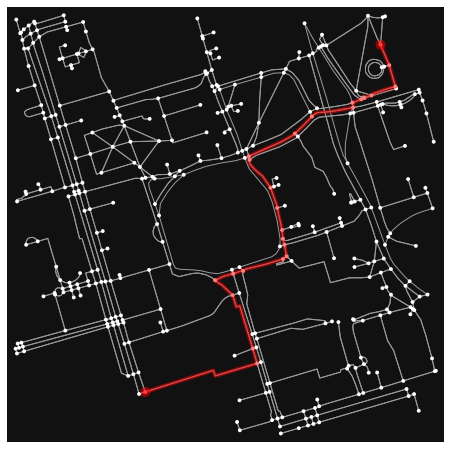

In [24]:
fig, ax = ox.plot_graph_route(G, current)

In [19]:
draw_route(G, route)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [20]:
states

[1205.6660000000002,
 1205.6660000000002,
 963.5990000000002,
 1133.8670000000002,
 1130.4700000000003,
 1034.104,
 1034.104,
 1034.104,
 1182.718,
 1182.718,
 1044.5960000000002,
 1139.2710000000002,
 1139.2710000000002,
 1090.3250000000003,
 1198.9989999999998,
 1228.6309999999999,
 1053.193,
 996.489,
 935.228,
 976.013,
 976.013,
 976.013,
 953.5359999999998,
 950.2839999999999,
 953.5359999999998,
 1010.2399999999998,
 979.8019999999999,
 901.31,
 903.9839999999999,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848.7659999999998,
 848

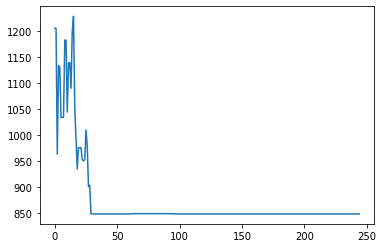

In [21]:
import matplotlib.pyplot as plt
plt.plot(states)
plt.show()